# Evaluate the Koshland-Goldbeter model as a description for the complete DMS dataset

Here we re-fit and evaluate the Koshland and Goldbeter model across the entire DHFR DMS dataset in the context of WT, Q33S, and R166Q TYMS. We start by fitting the model using point mutations that were previously catalytically characterized in vitro. We then use these best-fit parameters to infer kinetic parameters and examine model correspondence across the complete dataset. Finally, we explore the space of kinetic parameters inferred across the DMS dataset.

May 2022 - K. Reynolds

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib
import random
import pickle
import seaborn as sns
import math
import copy
import matplotlib.colors as colors

from scipy import stats
from scipy.optimize import least_squares
from scipy.optimize import basinhopping

### Import all of the relevant data (growth rates, biochemical parameters, and initial model fits based on plate reader data)

#### Relative growth rates (and errors) obtained by sequencing

In [2]:
#growth rates as calculated in 2_DMSGrowthRates.ipynb and then
#filtered in 3_Epistasis.ipynb
# gr_filt only includes DHFR variants with three replicate measurements
# (mutations that were absent from the library or showed insufficient reads 
# to allow growth rate fitting in at lease one replicate are replaced with a nan)
# data were then further filtered to truncate the first DHFR position and stop codons.
# mutations with negative growth rates are set to nan as well.
#WT alleles at each position have a fitness of 1

fin = open('Output/Epistasis.pkl','rb')
epi_data = pickle.load(fin)
gr_mean = epi_data['gr_filt']
gr_std = epi_data['gr_filt_std']
WTAAmask = epi_data['WTAAmask']
fin.close()

#epistasis (and errors) as calculated in 3_Epistasis.ipynb
epi = epi_data['epi']
epi_std = epi_data['epi_std']
fin.close()

#experimental parameters
TYMS_mut = list(gr_mean.keys())

#define the size of the mutational space
#and specify the sequence (and range) of each sublibrary
Npos = 159 
AA = 'GAVLMIFYWKRHDESTCNQP*' #here we order the amino acids by biochemical similarity
NAA = len(AA)
NAA_nostop = NAA - 1
wt_aa_sequence= {}
wt_aa_sequence['sl1']= 'MISLIAALAVDRVIGMENAMPWNLPADLAWFKRNTLNKPV'
wt_aa_sequence['sl2']= 'IMGRHTWESIGRPLPGRKNIILSSQPGTDDRVTWVKSVDE'
wt_aa_sequence['sl3']= 'AIAACGDVPEIMVIGGGRVYEQFLPKAQKLYLTHIDAEVE'
wt_aa_sequence['sl4']= 'GDTHFPDYEPDDWESVFSEFHDADAQNSHSYCFEILERR*'
wt_aa_seqfull = wt_aa_sequence['sl1']+wt_aa_sequence['sl2']+wt_aa_sequence['sl3']+wt_aa_sequence['sl4']

#### DHFR and TYMS kinetics data

In [3]:
#the mutant lists are sorted by catalytic power (kcat/Km)
DHFR_mut = ['L54F','WT','M42F','L28F','T113V','L28Y','F31Y','L54I','W22H','F31V','G121V','D27N']
TYMS_mut = ['WT','Q33S','R166Q']

#catalytic activities for DHFR are taken from Reynolds et al 2011 + Thompson et al 2020
#catalytic activities for TYMS were collected by Chris Ingle in triplicate
DHFR_kcat, DHFR_Km = {}, {}, 
DHFR_kcat_std, DHFR_Km_std = {},{} 
flines = open('Input/kinetics_dhfr.txt').readlines()[1:]
for line in flines:
    sp = line.split()
    DHFR_kcat[sp[0]] = float(sp[1])
    DHFR_Km[sp[0]] = float(sp[2])
    DHFR_kcat_std[sp[0]] = float(sp[3])
    DHFR_Km_std[sp[0]] = float(sp[4])

dhkcat_sel,dhkm_sel = np.zeros(len(DHFR_mut)),np.zeros(len(DHFR_mut))
dhkcat_std_sel,dhkm_std_sel = np.zeros_like(dhkcat_sel),np.zeros_like(dhkm_sel)
for i,dh in enumerate(DHFR_mut):
    dhkcat_sel[i] = DHFR_kcat[dh]
    dhkm_sel[i] = DHFR_Km[dh]
    dhkcat_std_sel[i] = DHFR_kcat_std[dh]
    dhkm_std_sel[i] = DHFR_Km_std[dh]
                             
TYMS_kcat, TYMS_Km = {}, {}
TYMS_kcat_std, TYMS_Km_std = {},{}
flines = open('Input/kinetics_tyms.txt').readlines()[1:]
for line in flines:
    sp = line.split()
    TYMS_kcat[sp[0]] = float(sp[1])
    TYMS_Km[sp[0]] = float(sp[2])
    TYMS_kcat_std[sp[0]] = float(sp[3])
    TYMS_Km_std[sp[0]] = float(sp[4])
    
tskcat_sel, tskm_sel = np.zeros(len(TYMS_mut)), np.zeros(len(TYMS_mut))
tskcat_std_sel, tskm_std_sel = np.zeros(len(TYMS_mut)), np.zeros(len(TYMS_mut))
for i,ts in enumerate(TYMS_mut):
    tskcat_sel[i] = TYMS_kcat[ts]
    tskm_sel[i] = TYMS_Km[ts]
    tskcat_std_sel[i] = TYMS_kcat_std[ts]
    tskm_std_sel[i] = TYMS_Km_std[ts]

#### Import the best fit model from the plate reader data 

(this should be a reasonable starting point for fitting the sequencing dataset)

In [4]:
fin = open('Output/model_fitplatedata.pkl','rb')

KGfit_plate = pickle.load(fin)
KGfit_plate

{'Ftot': 5.471310278469468,
 'c_ts': array([0.14031572, 0.27026646, 0.9289896 , 0.32781635]),
 'c_dh': 0.08345586894847508,
 'g_params': array([0.03605182, 1.56838458, 1.01568033, 0.18968792])}

### Define the model fitting functions 

(these are a subset of the model fitting functions in 1_KGModel.ipynb, but are otherwise identical)

In [5]:
def gr_depSigmoid(K,n,gmax,gmin,metab):
    '''
    Sigmoidal function relating metabolite concentration to growth rate.
    
    **Arguments:**
        K = metabolite concetration at 50% of maximal growth
        n = hill coefficient
        gmax = max growth rate
        gmin = min growth rate
        metab = metabolite concetrations
    '''
    gr = (gmax - gmin)/(1 + (K/metab)**n) + gmin
    return gr

def concTHF(Ftot,c_ts,c_dh,kc_ts,kc_dh,km_ts,km_dh):
    '''
    Calculate the steady state concentration of THF 
    using the Koshland-Goldbeter equation
    
    Returns the fraction of the total folate pool that
    corresponds to THF
    
    **Arguments:**
        Ftot = total folate pool
        c_ts = relative abundance of TYMS
        c_dh = relative abundace of DHFR
        kc_ts = kcat TYMS
        kc_dh = kcat DHFR
        km_ts = Km TYMS
        km_dh = Km DHFR
    '''
    v1 = kc_dh*c_dh
    v2 = kc_ts*c_ts
    km1 = km_dh/Ftot
    km2 = km_ts/Ftot
    p1 = (v1/v2)*(1-km2) - km1 - 1
    p2 = np.sqrt(4*km2*(v1/v2)*(v1/v2 - 1) + ((v1/v2)*(km2 - 1)+km1 + 1)**2)
    fracTHF = (p1 + p2)/(2*(v1/v2 - 1))
    return fracTHF
    
def calcGR(Ftot,c_ts,c_dh,kc_tsmut,kc_dhmut,km_tsmut,km_dhmut,g_params):
    '''
    Calculate the growth rate for select DHFR and TYMS mutant combinations
    given parameters for the KG model and THF-growth rate relationship.
    
    **Arguments:**
        Ftot = total folate pool
        c_ts = relative abundance of TYMS
        c_dh = relative abundace of DHFR
        kc_tsmut = kcat TYMS
        kc_dhmut = kcat DHFR
        km_tsmut = Km TYMS
        km_dhmut = Km DHFR
        g_params = array of four parameters for gr_depSigmoid (K,n,gmax,gmin)
    
    returns the estimated growth rates as either a scalar, array, or Ndh * Nts 
    matrix, depending on the number of input DHFR and TYMS kinetic parameters
    '''
    K,n,gmax,gmin = g_params
    
    #calculate a growth rate matrix
    if hasattr(kc_tsmut, "__len__") and hasattr(kc_dhmut, "__len__"):
        gr = np.zeros((len(kc_dhmut),len(kc_tsmut)))
        thfWT = concTHF(Ftot,c_ts[0],c_dh,TYMS_kcat['WT'],DHFR_kcat['WT'],TYMS_Km['WT'],DHFR_Km['WT'])
        for i in range(len(kc_dhmut)):
            for j in range(len(kc_tsmut)):
                thfMut = concTHF(Ftot,c_ts[j],c_dh,kc_tsmut[j],kc_dhmut[i],km_tsmut[j],km_dhmut[i])
                relTHF = thfMut/thfWT
                gr[i,j] =gr_depSigmoid(K,n,gmax,gmin,relTHF)
        return gr
    
    #calculate a growth rate vector
    elif hasattr(kc_tsmut, "__len__") and not(hasattr(kc_dhmut, "__len__")):
        gr = np.zeros(len(kc_tsmut))
        thfWT = concTHF(Ftot,c_ts[0],c_dh,TYMS_kcat['WT'],DHFR_kcat['WT'],TYMS_Km['WT'],DHFR_Km['WT'])
        for j in range(len(kc_tsmut)):
            thfMut = concTHF(Ftot,c_ts[j],c_dh,kc_tsmut[j],kc_dhmut,km_tsmut[j],km_dhmut)
            relTHF = thfMut/thfWT
            gr[j] = gr_depSigmoid(K,n,gmax,gmin,relTHF)
        return gr
    
    #calculate a single growth rate value
    else:
        thfMut = concTHF(Ftot,c_ts,c_dh,kc_tsmut,kc_dhmut,km_tsmut,km_dhmut)
        thfWT = concTHF(Ftot,c_ts,c_dh,TYMS_kcat['WT'],DHFR_kcat['WT'],TYMS_Km['WT'],DHFR_Km['WT'])
        relTHF = thfMut/thfWT
        gr = gr_depSigmoid(K,n,gmax,gmin,relTHF)
        return gr

    
def resids_grates(p,kc_ts,kc_dh,km_ts,km_dh,obs_grates,holdout=np.nan,cts='mult'):
    '''
    Calculate the difference between the observed and calculated
    growth rates, given a set of DHFR and TYMS catalytic parameters, 
    and selected fit parameters (p). Used to fit the complete set of 
    model parameters from a growth rate dataset. 
    
    **Arguments: **
        p = array of fit parameters (Ftot,cts,cdh,parameters for growth rate sigmoid)
        kc_ts = kcat TYMS
        kc_dh = kcat DHFR
        km_ts = Km TYMS
        km_dh = Km DHFR
        obs_grates = observed (experimental) growth rates
        holdout = (optional) data point to exclude during fitting
        cts = (optional) argument to specify if you wish to only fit a subset of tyms concentration values
              'mult' fits a tyms concentration for each mutant
              'two' fits two tyms concentrations - one for R166Q and one for everything else
               any other string results in fitting only a single tyms concentration parameter
    
    The holdout parameter is used to estimate sensitivity of the model fit parameters
    on the dataset (by bootstrap sampling the data)
    
    The function assumes that the observed growth rates are organized such that the
    (rows) match to the dhfr variants as orderd in kc_dh and km_dh, and that the 
    (columns) match to the tyms variants as ordered in kc_ts and km_ts
    '''
    
    #select whether to fit: (1) a unique relative concentration of TYMS for each
    #TYMS variant, OR (2) a relative concentration for TYMS R166Q and a single parameter for
    #all of the others OR (3) a single relative concentration of TYMS for all variants (one parameter)
    if (cts=='mult'):
        Ftot = p[0]
        cts =p[1:1+len(kc_ts)]
        cdh=p[1+len(kc_ts)]
        g_params = p[len(kc_ts)+2:]
    
    elif (cts == 'two'):
        Ftot = p[0]
        cts =np.ones(len(kc_ts))*p[1]
        cts[-1] = p[2]
        cdh=p[3]
        g_params = p[4:]
    
    else: 
        Ftot = p[0]
        cts =np.ones(len(kc_ts))*p[1]
        cdh=p[2]
        g_params = p[3:]
        
    gr_est = calcGR(Ftot,cts,cdh,kc_ts,kc_dh,km_ts,km_dh,g_params)
    
    if np.isnan(holdout):
        err = gr_est.flatten() - obs_grates.flatten()
    else:
        err = np.delete(gr_est,holdout) - np.delete(obs_grates,holdout)
    return err[~np.isnan(err)]


### Define functions for inferring catalytic parameters given growth rate data

These functions are used to evaluate the model as a description across the entire dataset.

In [6]:
def growth_obj(cat_params, gr_obs, tskc, tskm, p):
    '''
    Objective function for minimization, when estimating DHFR catalytic parameters from growth rate data
    Calculates the RMSD between the observed (gr_obs) and estimated growth rates 
    Given a specific choice of DHFR catalytic parameters (cat_params)
    
    **Arguments:**
        cat_params = a vector containing the selected DHFR kcat and Km [dh_kcat, dh_km]
        gr_obs = the observed growth rates for a given DHFR mutant across multiple TYMS backgrounds
        tskc = the TYMS kcat values corresponding to each TYMS background
        tskm = the TYMS Km values corresponding to each TYMS background
        p = the best-fit parameters for the Koshland-Goldbeter based growth rate model 
        
    returns the RMSD between the observed and predicted growth rate data for a given choice of
    DHFR kcat and Km 
    '''
    Ftot = p[0]
    cts =p[1:1+len(tskc)]
    cdh=p[1+len(tskc)]
    g_params = p[2+len(tskc):]
    gr_est = calcGR(Ftot,cts,cdh,tskc,cat_params[0],tskm,cat_params[1],g_params)
    err = np.sqrt(np.sum((gr_est - gr_obs)**2))
    return err

def it_bh2(gr,gr_err,niter,tskc,tskm,p):
    '''
    Solves for DHFR catalytic parameters that minimize the difference between an observed set of 
    growth rate measurements (gr) and the predictions. The minimizer is basinhopping, from scipy optimize.
    The function runs niter rounds of optimization, for each round the growth rates are sampled from a 
    normal distribution governed by the mean and standard deviation of our experimental measurements. 
    The optimal kcat and Km for each round of optimization are stored in the numpy array sols.
    
    **Arguments:**
        gr = the experimentally observed mean growth rates across a set of TYMS backgrounds
        gr_err = the experimentally observed std deviation in growth rates across a set of TYMS backgrounds
        niter = the number of iterations to perform
        p = the parameters for the Koshland-Goldbeter based growth rate model 
    
    returns sols, a vector of niter solutions - each solution consists of a paired kcat, Km value.
    '''
    bds = ((0.01,100),(0.1,1000))
    sols = np.zeros((niter,2))
    x0_kcat = np.random.uniform(bds[0][0],bds[0][1],niter)
    x0_km = np.random.uniform(bds[1][0],bds[1][1],niter)
    for i in range(niter):
        x0 = [x0_kcat[i],x0_km[i]]
        gr_var = [np.random.normal(gr[i],e) for i,e in enumerate(gr_err)]
        minargs = (gr_var,tskc,tskm,p)
        inputargs = {'bounds': bds, 'args': minargs}
        solution = basinhopping(growth_obj,x0,minimizer_kwargs=inputargs)
        sols[i,:] = solution.x
    return sols


### Fit and evaluate the model across all biochemically characterized single mutations.

We consider both (1) the fit using parameters derived from the plate reader data (as determined in 1_KGModel.ipynb) and (2) refitting the model parameters using the expanded set of characterized point mutations included in the DMS experiment. 

We evaluate the correlation between both parameter sets and the data for this focused set of a dozen mutations.

Fit parameters from plate reader data - Ftot: 5.47,     TYMS: 0.14,0.27,0.33,DHFR: 0.08, K: 0.04,n:1.57, mx:1.02,     mn: 0.19 
*** RMSD between the model and data - using params fit on plate reader data: 0.16
*** R2: 0.75
Best fit across mutations in sequencing set - Ftot: 24.94 (+/-14.01),    TYMS: 0.30 (+/-0.06),0.50 (+/-0.08),0.48 (+/-0.28),    DHFR: 0.11 (+/-0.03), K: 0.10 (+/-0.23),n:1.31 (+/-0.25), mx:1.03 (+/-0.17),     mn: 0.12 (+/-0.02)
*** RMSD between the model and data - using refit params for full model: 0.09
*** R2: 0.89


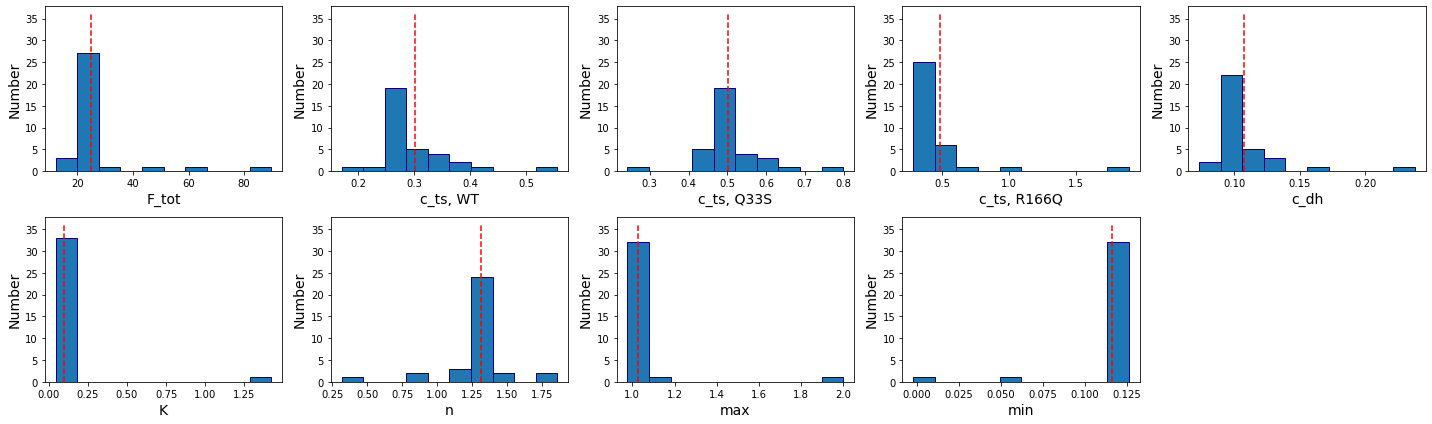

In [7]:
#define initial fitting parameters
p0 = [KGfit_plate['Ftot'],KGfit_plate['c_ts'][0],KGfit_plate['c_ts'][1],KGfit_plate['c_ts'][3],KGfit_plate['c_dh'],\
      KGfit_plate['g_params'][0],KGfit_plate['g_params'][1],KGfit_plate['g_params'][2],\
      KGfit_plate['g_params'][3]]
bds = ([0.0001,0.0001,0.0001,0.0001,0.0001,0.001,0,0.8,-0.3],[100,100,100,100,100,5,10,2,0.4])

#### organize the growth rate data for the focused set of mutations
grates_sel = np.zeros((len(DHFR_mut),len(TYMS_mut)))
grates_sel_std = np.zeros_like(grates_sel)
epi_sel,epi_sel_std = np.zeros_like(grates_sel),np.zeros_like(grates_sel)
for i,dmut in enumerate(DHFR_mut):
    for j,tmut in enumerate(TYMS_mut):
        if dmut == 'WT':
            grates_sel[i,j] = 1
            grates_sel_std[i,j] = 0
            epi_sel[i,j] = 0
            epi_sel_std[i,j]= 0
        else:    
            p = int(dmut[1:-1])-2
            a = AA.index(dmut[-1])
            grates_sel[i,j] = gr_mean[tmut][p,a]
            grates_sel_std[i,j] = gr_std[tmut][p,a]
            if tmut == 'WT':
                epi_sel[i,j] = 0
                epi_sel_std[i,j] = 0
            else:
                epi_sel[i,j] = epi[tmut][p,a]
                epi_sel_std[i,j] = epi_std[tmut][p,a]
            
        
#### calculate growth rates (and examine fit quality) using the initial parameter choices
# (these are the best fit values from the plate reader data)
gr_pred_oriparams = calcGR(p0[0],[p0[1],p0[2],p0[3]],p0[4],\
                           tskcat_sel,dhkcat_sel,tskm_sel,dhkm_sel,p0[5:])

#assess fit quality using the original set of best fit parameters (from the plate reader data)
nn = ~np.isnan(grates_sel.flatten())
N_meas = np.sum(nn)
rmsd_orifit = np.sqrt(np.sum((gr_pred_oriparams.flatten()[nn] - grates_sel.flatten()[nn])**2)/N_meas)
r2_orifit = np.corrcoef(grates_sel.flatten()[nn],gr_pred_oriparams.flatten()[nn])[0,1]**2
print('Fit parameters from plate reader data - Ftot: %1.2f, \
    TYMS: %1.2f,%1.2f,%1.2f,DHFR: %1.2f, K: %1.2f,n:%1.2f, mx:%1.2f, \
    mn: %1.2f ' % (p0[0],p0[1],p0[2],p0[3],p0[4],p0[5],p0[6],p0[7],p0[8]))
print('*** RMSD between the model and data - using params fit on plate reader data: %1.2f' % rmsd_orifit)
print('*** R2: %1.2f' % r2_orifit)


#### BOOTSTRAP ANALYSIS
# perform the model fit multiple times for the focused set of DHFR mutations, 
#leaving out a single experimental datapoint on each round 
Nsamp = N_meas
Ftot_samp =np.zeros((Nsamp,1))
c_ts_samp = np.zeros((Nsamp,3))
c_dh_samp = np.zeros((Nsamp,1))
g_params_samp = np.zeros((Nsamp,4))
gr_pred_samp = np.zeros((Nsamp,len(dhkcat_sel),len(tskcat_sel)))

for i in range(Nsamp):
    kg_fit = least_squares(resids_grates,p0,\
                               args=(tskcat_sel,dhkcat_sel,tskm_sel,dhkm_sel,grates_sel,i),\
                               bounds=bds)
    if kg_fit.success:
        Ftot_samp[i] = kg_fit.x[0]
        c_ts_samp[i,:] = kg_fit.x[1:4]
        c_dh_samp[i] = kg_fit.x[4]
        g_params_samp[i,:] = kg_fit.x[5:]
        gr_pred_samp[i,:,:] = calcGR(Ftot_samp[i],c_ts_samp[i,:],c_dh_samp[i],\
                                     tskcat_sel,dhkcat_sel,tskm_sel,dhkm_sel,\
                                     g_params_samp[i,:])
    
#calculate means and error on the parameters (across bootstrap samples)
Ftot, Ftot_std = np.mean(Ftot_samp),np.std(Ftot_samp)
c_ts, c_ts_std = np.mean(c_ts_samp,0),np.std(c_ts_samp,0)
c_dh, c_dh_std = np.mean(c_dh_samp),np.std(c_dh_samp)
g_params, g_params_std = np.mean(g_params_samp,0),np.std(g_params_samp,0)

#and report the best fit values:
print('Best fit across mutations in sequencing set - Ftot: %1.2f (+/-%1.2f),\
    TYMS: %1.2f (+/-%1.2f),%1.2f (+/-%1.2f),%1.2f (+/-%1.2f),\
    DHFR: %1.2f (+/-%1.2f), K: %1.2f (+/-%1.2f),n:%1.2f (+/-%1.2f), mx:%1.2f (+/-%1.2f), \
    mn: %1.2f (+/-%1.2f)' % (Ftot,Ftot_std,c_ts[0],c_ts_std[0],c_ts[1],c_ts_std[1],\
                             c_ts[2],c_ts_std[2],c_dh,c_dh_std,\
                            g_params[0],g_params_std[0],g_params[1],g_params_std[1],\
                            g_params[2],g_params_std[2],g_params[3],g_params_std[3]))


#calculate means and error on growth rates
gr_pred, gr_pred_err = np.mean(gr_pred_samp,0),np.std(gr_pred_samp,0)

#assess fit quality for the best fit model (averaging across bootstrap replicates)
rmsd_bestfit = np.sqrt(np.sum((gr_pred.flatten()[nn] - grates_sel.flatten()[nn])**2)/N_meas)
r2_bestfit = np.corrcoef(grates_sel.flatten()[nn],gr_pred.flatten()[nn])[0,1]**2
print('*** RMSD between the model and data - using refit params for full model: %1.2f' % rmsd_bestfit)
print('*** R2: %1.2f' % r2_bestfit)

#plot distributions of best fit parameters with means indicated. 
plt.figure(figsize =(20,6))
plt.subplot(2,5,1)
plt.hist(Ftot_samp,edgecolor='navy')
plt.plot([Ftot,Ftot],[0,36],'--r')
plt.xlabel('F_tot',fontsize=14); plt.ylabel('Number',fontsize=14)
plt.subplot(2,5,2)
plt.hist(c_ts_samp[:,0],edgecolor='navy')
plt.plot([c_ts[0],c_ts[0]],[0,36],'--r')
plt.xlabel('c_ts, WT',fontsize=14); plt.ylabel('Number',fontsize=14)
plt.subplot(2,5,3)
plt.hist(c_ts_samp[:,1],edgecolor='navy')
plt.plot([c_ts[1],c_ts[1]],[0,36],'--r')
plt.xlabel('c_ts, Q33S',fontsize=14); plt.ylabel('Number',fontsize=14)
plt.subplot(2,5,4)
plt.hist(c_ts_samp[:,2],edgecolor='navy')
plt.plot([c_ts[2],c_ts[2]],[0,36],'--r')
plt.xlabel('c_ts, R166Q',fontsize=14); plt.ylabel('Number',fontsize=14)
plt.subplot(2,5,5)
plt.hist(c_dh_samp,edgecolor='navy')
plt.plot([c_dh,c_dh],[0,36],'--r')
plt.xlabel('c_dh',fontsize=14); plt.ylabel('Number',fontsize=14)
plt.subplot(2,5,6)
plt.hist(g_params_samp[:,0],edgecolor='navy')
plt.plot([g_params[0],g_params[0]],[0,36],'--r')
plt.xlabel('K',fontsize=14); plt.ylabel('Number',fontsize=14)
plt.subplot(2,5,7)
plt.hist(g_params_samp[:,1],edgecolor='navy')
plt.plot([g_params[1],g_params[1]],[0,36],'--r')
plt.xlabel('n',fontsize=14); plt.ylabel('Number',fontsize=14)
plt.subplot(2,5,8)
plt.hist(g_params_samp[:,2],edgecolor='navy')
plt.plot([g_params[2],g_params[2]],[0,36],'--r')
plt.xlabel('max',fontsize=14); plt.ylabel('Number',fontsize=14)
plt.subplot(2,5,9)
plt.hist(g_params_samp[:,3],edgecolor='navy')
plt.plot([g_params[3],g_params[3]],[0,36],'--r')
plt.xlabel('min',fontsize=14); plt.ylabel('Number',fontsize=14)

plt.tight_layout()
plt.savefig('Figs/HistFitParams_SeqData.pdf')

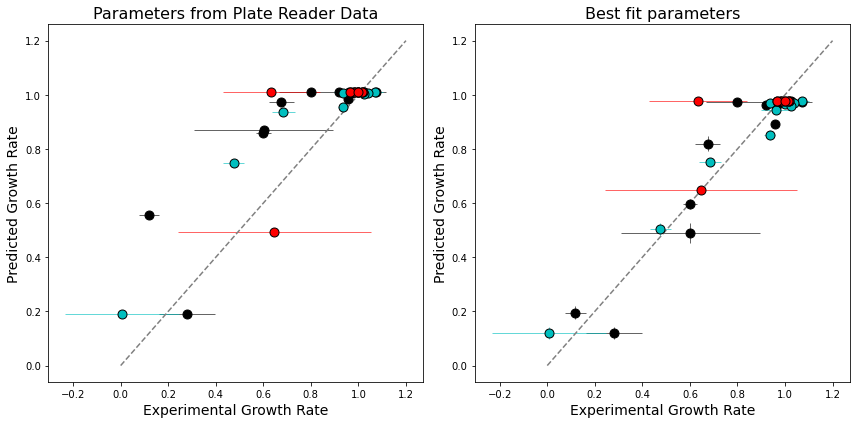

In [8]:
##### Plotting the results
plt.figure(figsize = (12,6))
ts_col = ['k','c','r']

#### predicted vs experimental growth rates (taking parameters from plate reader fit)
plt.subplot(121)
for i,ts in enumerate(TYMS_mut):
    plt.errorbar(grates_sel[:,i],gr_pred_oriparams[:,i],xerr=grates_sel_std[:,i],\
                 fmt='o',ms=9,mec='k',color=ts_col[i],mfc=ts_col[i],elinewidth=0.6)
plt.plot([0,1.2],[0,1.2],'--',color='grey')

#uncomment to add text labels for individual mutations on the plot
#for i,dmut in enumerate(DHFR_mut):
#    for j,tmut in enumerate(TYMS_mut):
#            plt.text(grates_sel[i,j],gr_pred_oriparams[i,j]+0.02,dmut+'/'+tmut)

plt.title('Parameters from Plate Reader Data',fontsize=16)            
plt.xlabel('Experimental Growth Rate', fontsize=14)
plt.ylabel('Predicted Growth Rate', fontsize=14)
   
    
#### predicted vs experimental growth rates (with the best fit parameters)
plt.subplot(122)
for i,ts in enumerate(TYMS_mut):
    plt.errorbar(grates_sel[:,i],gr_pred[:,i],xerr=grates_sel_std[:,i],yerr=gr_pred_err[:,i],\
                 fmt='o',color=ts_col[i],ms=9,mec='k',mfc=ts_col[i],elinewidth=0.6)
plt.plot([0,1.2],[0,1.2],'--',color='grey')

#uncomment to add text labels for individual mutations on the plot
#for i,dmut in enumerate(DHFR_mut):
#    for j,tmut in enumerate(TYMS_mut):
#            plt.text(grates_sel[i,j],gr_pred[i,j]+0.02,dmut+'/'+tmut)

plt.title('Best fit parameters',fontsize=16)            
plt.xlabel('Experimental Growth Rate', fontsize=14)
plt.ylabel('Predicted Growth Rate', fontsize=14)  

plt.tight_layout()
plt.savefig('Figs/BestFit_ModelSeqData.pdf')

#### Compare the predicted and experimental values as heatmaps

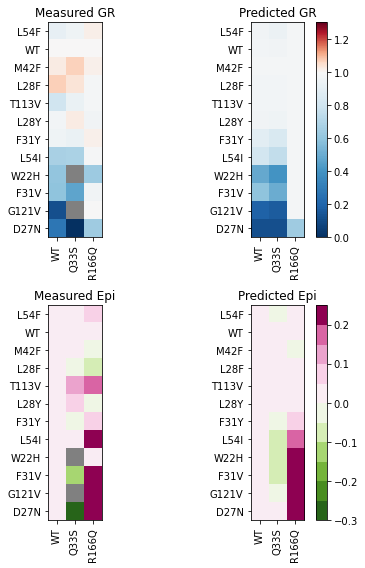

In [9]:
epi_pred = np.zeros_like(grates_sel)

#create heatmap for growth rates
vmn = 0;vmx = 1.3
norm_gr = colors.TwoSlopeNorm(vmin=vmn, vcenter=1, vmax=vmx)
cmap_gr = copy.copy(plt.cm.get_cmap("RdBu_r"))
cmap_gr.set_bad(color='grey') 

#create discretized colormap for epistasis
bounds = np.arange(-0.3, 0.3, 0.05)
base = plt.cm.get_cmap('PiYG_r')
cmap_discrete = base(np.linspace(0,1,len(bounds)))
newmap = colors.ListedColormap(cmap_discrete)
newmap.set_bad(color='grey') 
norm_epi = colors.BoundaryNorm(bounds,newmap.N)


for i,dh in enumerate(DHFR_mut):
    for j,ts in enumerate(TYMS_mut):
        epi_pred[i,j] = gr_pred[i,j] + (gr_pred[1,0] - gr_pred[i,0] - gr_pred[1,j])

plt.figure(figsize = (6,8))
plt.subplot(2,2,1)
plt.imshow(grates_sel,cmap=cmap_gr,norm=norm_gr)
plt.title('Measured GR')
plt.yticks(np.arange(0,len(DHFR_mut)),\
                             labels=DHFR_mut)
plt.xticks(np.arange(0,len(TYMS_mut)),\
                             labels=TYMS_mut,\
                             rotation='vertical')

plt.subplot(2,2,2)
plt.imshow(gr_pred,cmap=cmap_gr,norm=norm_gr)
plt.title('Predicted GR'); plt.colorbar()
plt.yticks(np.arange(0,len(DHFR_mut)),\
                             labels=DHFR_mut)
plt.xticks(np.arange(0,len(TYMS_mut)),\
                             labels=TYMS_mut,\
                             rotation='vertical')

plt.subplot(2,2,3)
plt.imshow(epi_sel,cmap=newmap,norm=norm_epi)
plt.title('Measured Epi')
plt.yticks(np.arange(0,len(DHFR_mut)),\
                             labels=DHFR_mut)
plt.xticks(np.arange(0,len(TYMS_mut)),\
                             labels=TYMS_mut,\
                             rotation='vertical')
plt.subplot(2,2,4)
plt.imshow(epi_pred,cmap=newmap,norm=norm_epi)
plt.title('Predicted Epi'); plt.colorbar()
plt.yticks(np.arange(0,len(DHFR_mut)),\
                             labels=DHFR_mut)
plt.xticks(np.arange(0,len(TYMS_mut)),\
                             labels=TYMS_mut,\
                             rotation='vertical')

plt.tight_layout()
plt.savefig('Figs/PredictedHeatMaps.pdf')

### Fitting catalytic parameters to the remaining point mutations in the dataset

First we consider only the subset of point mutants that were previously biochemically characterized

In [10]:
#estimate kcat and Km values
est_kcat,est_kcat_std,est_Km,est_Km_std = [],[],[],[]
fit_params = np.append(np.append(np.append(Ftot,c_ts),c_dh),g_params)
for i,mut in enumerate(DHFR_mut):
    niter=50
    if np.nan in grates_sel[i,:]:
        est_kcat.append(np.nan)
        est_Km.append(np.nan)
        est_kcat_std.append(np.nan)
        est_Km_std.append(np.nan)
    else:    
        sols = it_bh2(grates_sel[i,:],grates_sel_std[i,:],niter,tskcat_sel,tskm_sel,fit_params)
        est_kcat.append(np.median(sols[:,0]))
        est_Km.append(np.median(sols[:,1]))
        est_kcat_std.append(np.std(sols[:,0]))
        est_Km_std.append(np.std(sols[:,1]))

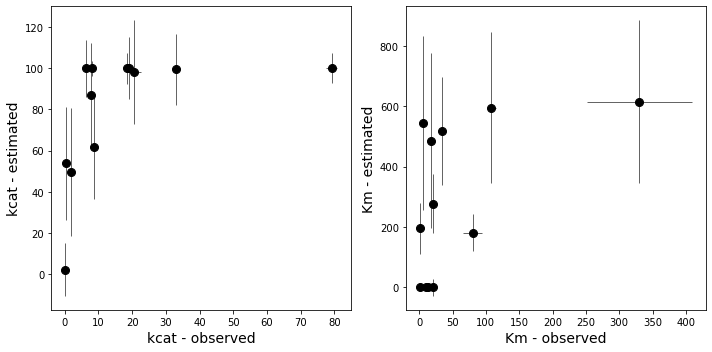

In [11]:
#plot the results
plt.figure(figsize = (10,5))
plt.subplot(121)
plt.errorbar(dhkcat_sel,est_kcat,xerr=dhkcat_std_sel,yerr=est_kcat_std,fmt='o',color='black',ms=8,\
             elinewidth=0.6,linestyle='')  
plt.xlabel('kcat - observed', fontsize = 14)
plt.ylabel('kcat - estimated', fontsize = 14)
    
plt.subplot(122)
plt.errorbar(dhkm_sel,est_Km,xerr=dhkm_std_sel,yerr=est_Km_std,fmt='o',color='black',ms=8,\
             linestyle='', elinewidth=0.6)
plt.xlabel('Km - observed', fontsize = 14)
plt.ylabel('Km - estimated', fontsize = 14)
plt.tight_layout()

While there is some approximate relationship between the estimated and observed kinetic parameters, clearly the model does not fully constrain the catalytic parameters for individual DHFR mutations. The Km values seem to be particularly challenging to estimate from the growth rate data

#### To investigate this more closely, we  consider the RMSD between the model and the data over a range of choices in kcat and Km values. 

A more constrained model will yield low RMSDs to the data over a narrow window of kcat and Km parameter choices. In contrast, a less constrained model will show many degenerate "good" solutions. The possibility of many reasonable solutions for kcat and Km is particularly obvious for mutations that grow well in all three TYMS backgounds - in this case the model cannot discriminate between kcat/Km values which are near WT and those which are much better.

Estimated growth rate M42F - known params: 
[[0.99327074 0.99287275 0.9952371 ]]
Estimated growth rate M42F - best fit: 
[0.99522698 0.99522489 0.99523822]
Actual growth rate: 
[1.02376593 1.07003509 1.01529719]
Error known params: 0.085360, error best fit 0.082543
Estimated growth rate F31V - known params: 
[[0.44245021 0.3607546  0.99515238]]
Estimated growth rate F31V - best fit: 
[0.58074761 0.48627466 0.99516954]
Actual growth rate: 
[0.60032238 0.47525284 0.96628721]
Error known params: 0.197146, error best fit 0.036590
Estimated growth rate D27N - known params: 
[[0.11662713 0.11658495 0.48062627]]
Estimated growth rate D27N - best fit: 
[0.11665742 0.11660523 0.64916552]
Actual growth rate: 
[0.2796503  0.00658939 0.64688074]
Error known params: 0.257519, error best fit 0.196661


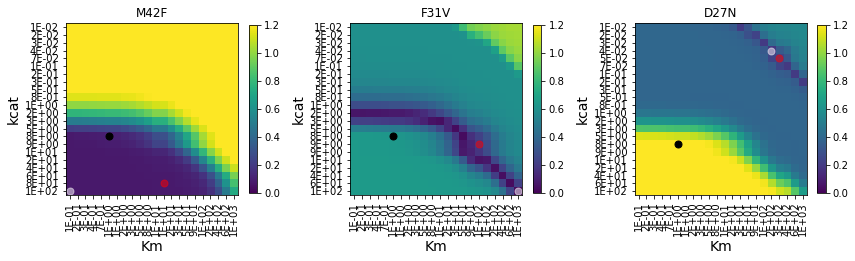

In [12]:
mut2try = ['M42F','F31V','D27N']

plt.rcParams['figure.figsize'] = 12,12
for i,moi in enumerate(mut2try):
    plt.subplot(1,3,i+1)
    dhkcat_vary = np.sort(np.append(np.append(np.logspace(-2,2,20),DHFR_kcat[moi]),DHFR_kcat['WT']))
    dhKm_vary = np.sort(np.append(np.append(np.logspace(-1,3,20),DHFR_Km[moi]),DHFR_Km['WT']))
    ix_kcmoi = np.where(dhkcat_vary == DHFR_kcat[moi])
    ix_kmmoi = np.where(dhKm_vary == DHFR_Km[moi])
    ix_kcwt = np.where(dhkcat_vary == DHFR_kcat['WT'])
    ix_kmwt = np.where(dhKm_vary == DHFR_Km['WT'])

    gr_err = np.zeros((len(dhkcat_vary),len(dhKm_vary)))
    for i,kc in enumerate(dhkcat_vary):
        for j,km in enumerate(dhKm_vary):
            gr_err[i,j] = growth_obj([kc,km],grates_sel[DHFR_mut.index(moi),:],tskcat_sel,tskm_sel,fit_params)
        
    gr_est = calcGR(fit_params[0],fit_params[1:1+len(tskcat_sel)],fit_params[1+len(tskcat_sel)],\
                    tskcat_sel,dhkcat_vary[ix_kcmoi],tskm_sel,dhKm_vary[ix_kmmoi],fit_params[2+len(tskcat_sel):])
    ix = np.where(gr_err == np.min(gr_err))
    gr_est2 = calcGR(fit_params[0],fit_params[1:1+len(tskcat_sel)],fit_params[1+len(tskcat_sel)],\
                    tskcat_sel,dhkcat_vary[ix[0][0]],tskm_sel,dhKm_vary[ix[1][0]],fit_params[2+len(tskcat_sel):])
    print('Estimated growth rate %s - known params: ' % moi)
    print(gr_est)
    print('Estimated growth rate %s - best fit: ' % moi)
    print(gr_est2)
    print('Actual growth rate: ')
    print(grates_sel[DHFR_mut.index(moi),:])
    print('Error known params: %f, error best fit %f' % (np.sqrt(np.sum((gr_est - grates_sel[DHFR_mut.index(moi),:])**2)), \
                                                         np.min(gr_err)))
    
    plt.imshow(gr_err,cmap='viridis', vmin=0,vmax=1.2)
    plt.plot(ix_kmmoi,ix_kcmoi,'or',ms=7,alpha=0.5)
    plt.plot(ix_kmwt,ix_kcwt,'ok',ms=7)
    plt.plot(ix[1][0],ix[0][0],'ow',ms=7,alpha=0.5)
    plt.yticks(np.arange(0,len(dhkcat_vary)),labels=['%1.0E'%p for p in dhkcat_vary],\
                     rotation='horizontal')
    plt.xticks(np.arange(0,len(dhKm_vary)),labels=['%1.0E'%p for p in dhKm_vary],\
                     rotation='vertical')
    plt.title(moi)
    plt.colorbar(shrink=0.2)
    plt.xlabel('Km',fontsize=14)
    plt.ylabel('kcat',fontsize=14)
plt.tight_layout()
plt.savefig('Figs/CatParam_Estimate.pdf')

In the above plots, the black point marks WT kinetic parameters, red indicates the actual (experimentally measured) parameters, and white marks the best fit parameters. For M42F (left panel), which has a kcat better than WT, the model can't clearly discriminate between many "good" values for kcat and Km. 

#### Examine how the model fits the data in totality

Now we investigate how the model describes the complete data set. We start by estimating catalytic parameters for all of the single mutants (for which we have growth rate measurements)

(this next code block takes several hours to run, it can be made faster by decreasing the argument niter)

In [13]:
ekcat,ekcat_std,eKm,eKm_std = np.zeros_like(gr_mean['WT']),np.zeros_like(gr_mean['WT']),\
                              np.zeros_like(gr_mean['WT']),np.zeros_like(gr_mean['WT'])
niter=20

for p in range(Npos-1):
    print('estimating effects for position %i' % p)
    for a in range(NAA_nostop):
        grf = [gr_mean['WT'][p,a],gr_mean['Q33S'][p,a],gr_mean['R166Q'][p,a]]
        grerr = [gr_std['WT'][p,a],gr_std['Q33S'][p,a],gr_std['R166Q'][p,a]]
        if np.sum(np.isnan(grf)) > 0:
            ekcat[p,a] = np.nan
            eKm[p,a] = np.nan
            ekcat_std[p,a] = np.nan
            eKm_std[p,a] = np.nan
        else:
            sols = it_bh2(grf,grerr,niter,tskcat_sel,tskm_sel,fit_params)
            ekcat[p,a] = np.median(sols[:,0])
            eKm[p,a] = np.median(sols[:,1])
            ekcat_std[p,a] = np.std(sols[:,0])
            eKm_std[p,a] = np.std(sols[:,1])

estimating effects for position 0
estimating effects for position 1
estimating effects for position 2
estimating effects for position 3
estimating effects for position 4
estimating effects for position 5
estimating effects for position 6
estimating effects for position 7
estimating effects for position 8
estimating effects for position 9
estimating effects for position 10
estimating effects for position 11
estimating effects for position 12
estimating effects for position 13
estimating effects for position 14
estimating effects for position 15
estimating effects for position 16
estimating effects for position 17
estimating effects for position 18
estimating effects for position 19
estimating effects for position 20
estimating effects for position 21
estimating effects for position 22
estimating effects for position 23
estimating effects for position 24
estimating effects for position 25
estimating effects for position 26
estimating effects for position 27
estimating effects for positio

Estimate back the growth rates from the best fits. 

In [14]:
gr_estall = {}
gr_estall['WT'] = np.zeros_like(gr_mean['WT'])
gr_estall['Q33S'] = np.zeros_like(gr_mean['Q33S'])
gr_estall['R166Q'] = np.zeros_like(gr_mean['R166Q'])

for p in range(Npos-1):
    for a in range(NAA_nostop):
        if ~np.isnan(ekcat[p,a]):
            gr_est = calcGR(Ftot,c_ts,c_dh,tskcat_sel,ekcat[p,a],tskm_sel,eKm[p,a],g_params)
            gr_estall['WT'][p,a] = gr_est[0]
            gr_estall['Q33S'][p,a] = gr_est[1]
            gr_estall['R166Q'][p,a] = gr_est[2]
        else:
            gr_estall['WT'][p,a] = np.nan
            gr_estall['Q33S'][p,a] = np.nan
            gr_estall['R166Q'][p,a] = np.nan

Examine the correspondence between the model and the data

Text(27.0, 0.5, 'Model Growth Rates')

<Figure size 576x432 with 0 Axes>

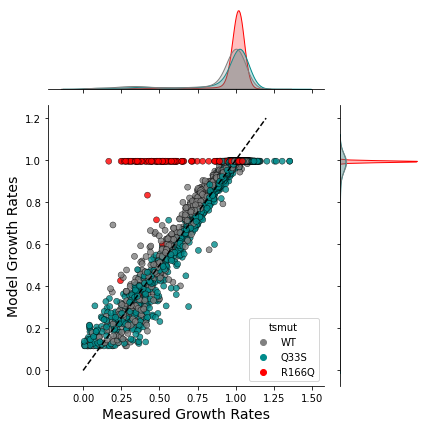

In [15]:
#create a dataframe to make seaborn plotting simpler
gr_model = {}
gr_model['dhmut'] = []
gr_model['tsmut'] = []
gr_model['gr_meas'] = np.zeros(len(gr_estall['WT'].flatten())*len(TYMS_mut))
gr_model['gr_mod'] = np.zeros(len(gr_estall['WT'].flatten())*len(TYMS_mut))

ix=0
for p in range(Npos-1):
    for a in range(NAA_nostop):
        for t in TYMS_mut:
            gr_model['dhmut'].append(str(p+1)+AA[a])
            gr_model['tsmut'].append(t)
            gr_model['gr_meas'][ix] = gr_mean[t][p,a]
            gr_model['gr_mod'][ix] = gr_estall[t][p,a]
            ix += 1

df_grmodel = pd.DataFrame(gr_model)

plt.figure(figsize=(8,6))
g = sns.jointplot(data=df_grmodel,x="gr_meas",y="gr_mod",hue="tsmut",palette=["grey","darkcyan","red"],\
                  ratio=3,joint_kws=dict(edgecolor='black',alpha=0.8))
plt.sca(g.ax_joint)
plt.plot([0,1.2],[0,1.2],'--k')
g.ax_joint.set_xlabel(('Measured Growth Rates'),fontsize=14)
g.ax_joint.set_ylabel(('Modeled Growth Rates'),fontsize=14)

#plt.plot(gr_mean['WT'].flatten(),gr_estall['WT'].flatten(),'o',markersize=6,color='grey',mec='grey',alpha=0.5)
#plt.plot(gr_mean['Q33S'].flatten(),gr_estall['Q33S'].flatten(),'o',markersize=6,color='cyan',mec='grey',alpha=0.5)
#plt.plot(gr_mean['R166Q'].flatten(),gr_estall['R166Q'].flatten(),'o',markersize=6,color='red',mec='grey',alpha=0.5)
#plt.plot([0, 1],[0, 1],'--k',linewidth=0.5)
plt.xlabel('Measured Growth Rates', fontsize=14)
plt.ylabel('Model Growth Rates', fontsize=14)

#### Plot the data onto fitness landscapes described by the model

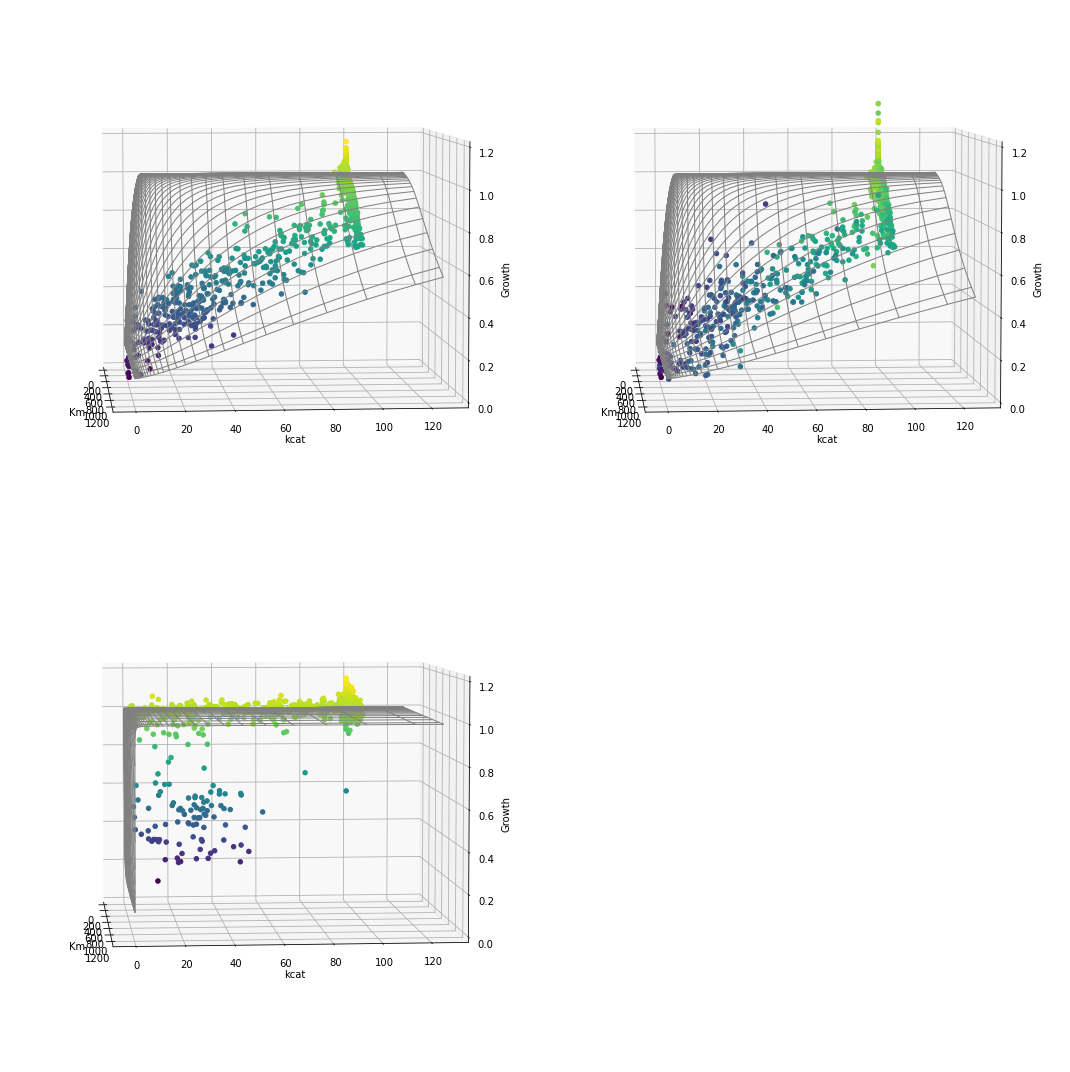

In [16]:
dhkcat_vary = np.logspace(-2,2.1,100)
dhKm_vary = np.logspace(-1,3.1,100)
gr_surf = {}
gr_surf['WT'] = np.zeros((len(dhkcat_vary),len(dhKm_vary)))
gr_surf['Q33S'] = np.zeros((len(dhkcat_vary),len(dhKm_vary)))
gr_surf['R166Q'] = np.zeros((len(dhkcat_vary),len(dhKm_vary)))

for i,kc in enumerate(dhkcat_vary):
    for j,km in enumerate(dhKm_vary):
        gr = calcGR(Ftot,c_ts,c_dh,tskcat_sel,kc,tskm_sel,km,g_params)
        gr_surf['WT'][i,j] = gr[0]
        gr_surf['Q33S'][i,j] = gr[1]
        gr_surf['R166Q'][i,j] = gr[2]
        
X,Y = np.meshgrid(dhKm_vary,dhkcat_vary)

plt.figure(figsize=(15,15))

ax=plt.subplot(221,projection='3d')
ax.plot_wireframe(X,Y,gr_surf['WT'],1,color='grey')
ax.scatter3D(eKm.flatten(),ekcat.flatten(),gr_mean['WT'][:,:20].flatten(),c=gr_mean['WT'][:,:20].flatten(),\
             cmap='viridis',alpha=1)
ax.set_zlim([0,1.2])
ax.view_init(5,-5)
ax.set_xlabel('Km')
ax.set_ylabel('kcat')
ax.set_zlabel('Growth')

ax = plt.subplot(222,projection='3d')
ax.plot_wireframe(X,Y,gr_surf['Q33S'],1,color='grey')
ax.scatter3D(eKm.flatten(),ekcat.flatten(),gr_mean['Q33S'][:,:20].flatten(),c=gr_mean['WT'][:,:20].flatten(),\
             cmap='viridis',alpha=1)
ax.set_zlim([0,1.2])
ax.view_init(5,-5)
ax.set_xlabel('Km')
ax.set_ylabel('kcat')
ax.set_zlabel('Growth')

ax = plt.subplot(223,projection='3d')
ax.plot_wireframe(X,Y,gr_surf['R166Q'],1,color='grey')
ax.scatter3D(eKm.flatten(),ekcat.flatten(),gr_mean['R166Q'][:,:20].flatten(),c=gr_mean['R166Q'][:,:20].\
             flatten(),cmap='viridis',alpha=1)
ax.set_zlim([0,1.2])
ax.view_init(5,-5)
ax.set_xlabel('Km')
ax.set_ylabel('kcat')
ax.set_zlabel('Growth')

plt.tight_layout()

#### Inspect the distribution of estimated kinetic parameters

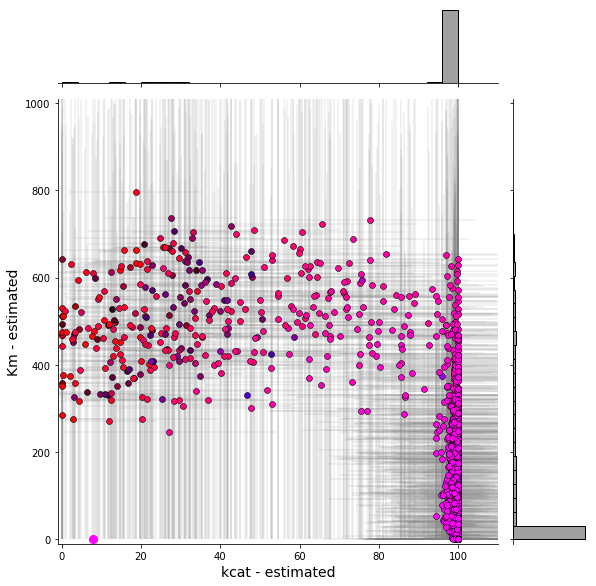

In [17]:
g = sns.jointplot(x=ekcat.flatten(),y=eKm.flatten(),marginal_kws=dict(bins=25,edgecolor='black',color='grey'),\
                  height=8)
for p in range(Npos-1):
    for a in range(NAA-1):
        if (~np.isnan(ekcat[p,a]) and (gr_mean['R166Q'][p,a] >= 0)) and (gr_mean['Q33S'][p,a] >= 0):
            g1 = gr_mean['R166Q'][p,a] if (gr_mean['R166Q'][p,a] < 1.0) else 1.0
            g2 = gr_mean['Q33S'][p,a] if (gr_mean['Q33S'][p,a] < 1.0) else 1.0
    
            #color code each point by it's growth rate in the R166Q (red) and
            #Q33S (blue) backgrounds
            colcode = (g1,0,g2,1)
            g.ax_joint.errorbar(ekcat[p,a],eKm[p,a],xerr=ekcat_std[p,a],\
                        yerr=eKm[p,a],fmt='o',markersize=6,\
                        color=colcode,mec='black',ecolor='grey', mew=0.5,elinewidth=0.2)

plt.sca(g.ax_joint)
plt.xlabel('kcat - estimated', fontsize=14)
plt.ylabel('Km - estimated', fontsize=14)
plt.xlim([-1,110]); plt.ylim([-10,1010])
plt.plot(DHFR_kcat['WT'],DHFR_Km['WT'],'o',color=(1,0,1,1),ms=8)

#### Write the results of our model fitting and parameter estimation to a pickle file

In [18]:
model_fits = {}
model_fits['Ftot'] = Ftot
model_fits['c_ts'] = c_ts
model_fits['c_dh'] = c_dh
model_fits['g_params'] = g_params
model_fits['ekcat'] = ekcat
model_fits['ekcat_std'] = ekcat_std
model_fits['eKm'] = eKm
model_fits['eKm_std'] = eKm_std 
model_fits['gr_est'] = gr_est

fout = open('Output/KGfit_alldata.pkl','wb')
pickle.dump(model_fits,fout, protocol=pickle.HIGHEST_PROTOCOL)
fout.close()